## Setup & Config

In [ ]:
!nvidia-smi

Thu Jan 28 06:23:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 12.4MB/s 
     |████████████████████████████████| 890kB 56.2MB/s 
     |████████████████████████████████| 3.0MB 57.7MB/s 
     |████████████████████████████████| 1.2MB 55.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=20255a76f6248ba9b05f44a1d7e51a7a1ba407a32c13795a3ac345c271fa3954
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.0.0


In [ ]:
import logging 
logging.basicConfig(level = logging.ERROR)

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Import Data (and Filter)

In [ ]:
# We import 4 datasets here

from google.colab import drive
drive.mount('/content/drive')
dftr = pd.read_csv('/content/drive/MyDrive/Applied NLP with Deep Learning/trump_rally_comments_fox.csv')
dftr2 = pd.read_csv('/content/drive/MyDrive/Applied NLP with Deep Learning/trump_pennsylvania_comments_fox.csv')
dfbd = pd.read_csv('/content/drive/MyDrive/Applied NLP with Deep Learning/biden_victory_comments_cnn.csv')
dfbd2 = pd.read_csv('/content/drive/MyDrive/Applied NLP with Deep Learning/biden_inauguration_comments_cnn.csv')

Mounted at /content/drive


In [ ]:
dftr.head()

,video_id,video_title,comment_date,comments,like_count,label_highlow
0,PWTb4r7h9ew,Trump speaks at 'Make America Great Again' ral...,2021-01-19T22:49:10Z,We Love you Donald trump You truly we...,1.0,0
1,PWTb4r7h9ew,Trump speaks at 'Make America Great Again' ral...,2021-01-09T02:43:15Z,Where is john wilks booth when you re...,1.0,0
2,PWTb4r7h9ew,Trump speaks at 'Make America Great Again' ral...,2021-01-07T22:28:22Z,Democrats Have MOCKED GOD LEFTIST WILL N...,2.0,0
3,PWTb4r7h9ew,Trump speaks at 'Make America Great Again' ral...,2021-01-07T02:39:04Z,He s right more people than th...,1.0,0
4,PWTb4r7h9ew,Trump speaks at 'Make America Great Again' ral...,2021-01-03T02:25:45Z,The reason Joe didn t have many ...,7.0,1


In [ ]:
dftr2.head()

,video_id,video_title,comment_date,comments,like_count,label_highlow
0,xWrtgnCTmj4,Trump delivers remarks in Pennsylvania,2021-01-25T10:14:26Z,I wonder what YouTube is going to do with this...,1.0,0
1,xWrtgnCTmj4,Trump delivers remarks in Pennsylvania,2021-01-22T11:43:53Z,Remember there was only one perfect person Do...,2.0,0
2,xWrtgnCTmj4,Trump delivers remarks in Pennsylvania,2021-01-18T01:47:56Z,President Trump You better elect me br Amer...,3.0,1
3,xWrtgnCTmj4,Trump delivers remarks in Pennsylvania,2021-01-17T01:49:40Z,The greatest president in the history of the U...,1.0,0
4,xWrtgnCTmj4,Trump delivers remarks in Pennsylvania,2021-01-12T20:23:15Z,He made mistakes in Washington how presucude a...,1.0,0


In [ ]:
dfbd.head()

,video_id,video_title,comment_date,comments,like_count,label_highlow
0,eolEz_jU-vs,Joe Biden addresses the nation after election ...,2021-01-01T02:45:13Z,Finally we ll have a real pres...,29.0,0
1,eolEz_jU-vs,Joe Biden addresses the nation after election ...,2020-11-14T09:23:56Z,The majority of Americans who voted for ...,6.0,0
2,eolEz_jU-vs,Joe Biden addresses the nation after election ...,2020-11-13T17:29:51Z,If this was his victory speech I can ...,24.0,0
3,eolEz_jU-vs,Joe Biden addresses the nation after election ...,2020-11-12T20:04:23Z,That moment at a href https www ...,26.0,0
4,eolEz_jU-vs,Joe Biden addresses the nation after election ...,2020-11-11T09:48:14Z,Congrats Mr President elect wish u w...,7.0,0


In [ ]:
dfbd2.head()

,video_id,video_title,comment_date,comments,like_count,label_highlow
0,LGukNIEIhTU,Watch President Joe Biden's full inauguration ...,2021-01-27T03:20:34Z,Biden signing executive orders br quot ...,5.0,1
1,LGukNIEIhTU,Watch President Joe Biden's full inauguration ...,2021-01-26T16:06:41Z,The problem with internet quotes is that you ...,7.0,1
2,LGukNIEIhTU,Watch President Joe Biden's full inauguration ...,2021-01-26T06:24:40Z,Joe Biden In this hour Democracy has Prevaile...,2.0,0
3,LGukNIEIhTU,Watch President Joe Biden's full inauguration ...,2021-01-25T20:38:08Z,My father Joe was a mistake I am tired of cov...,2.0,0
4,LGukNIEIhTU,Watch President Joe Biden's full inauguration ...,2021-01-25T20:38:03Z,My father Joe was a mistake I am tired of cov...,2.0,0


In [ ]:
# We merge datasets here and then filter and select
# the only highly liked comments. Then arrange each 
# comment's label according to video that it's been commented 
titles = dict()
titles['tr_title'] = dftr['video_title'].unique()[0]
titles['tr_title2'] = dftr2['video_title'].unique()[0]
titles['bd_title'] = dfbd['video_title'].unique()[0]
titles['bd_title2'] = dfbd2['video_title'].unique()[0]

dftr_ = dftr[dftr['label_highlow'] == 1].copy()
dftr_2 = dftr2[dftr2['label_highlow'] == 1].copy()
dfbd_ = dfbd[dfbd['label_highlow'] == 1].copy()
dfbd_2 = dfbd2[dfbd2['label_highlow'] == 1].copy()

dftrbd = pd.concat([dftr_,dfbd_],ignore_index=True)
dftrbd = pd.concat([dftrbd,dftr_2],ignore_index=True)
dftrbd = pd.concat([dftrbd,dfbd_2],ignore_index=True)

def label_on_video_title(x):
  if (x[1] == titles['tr_title']) or (x[1] == titles['tr_title2']):
    return 0
  elif (x[1] == titles['bd_title']) or (x[1] == titles['bd_title2']):
    return 1

dftrbd['label_trbd'] = dftrbd.apply(label_on_video_title, axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


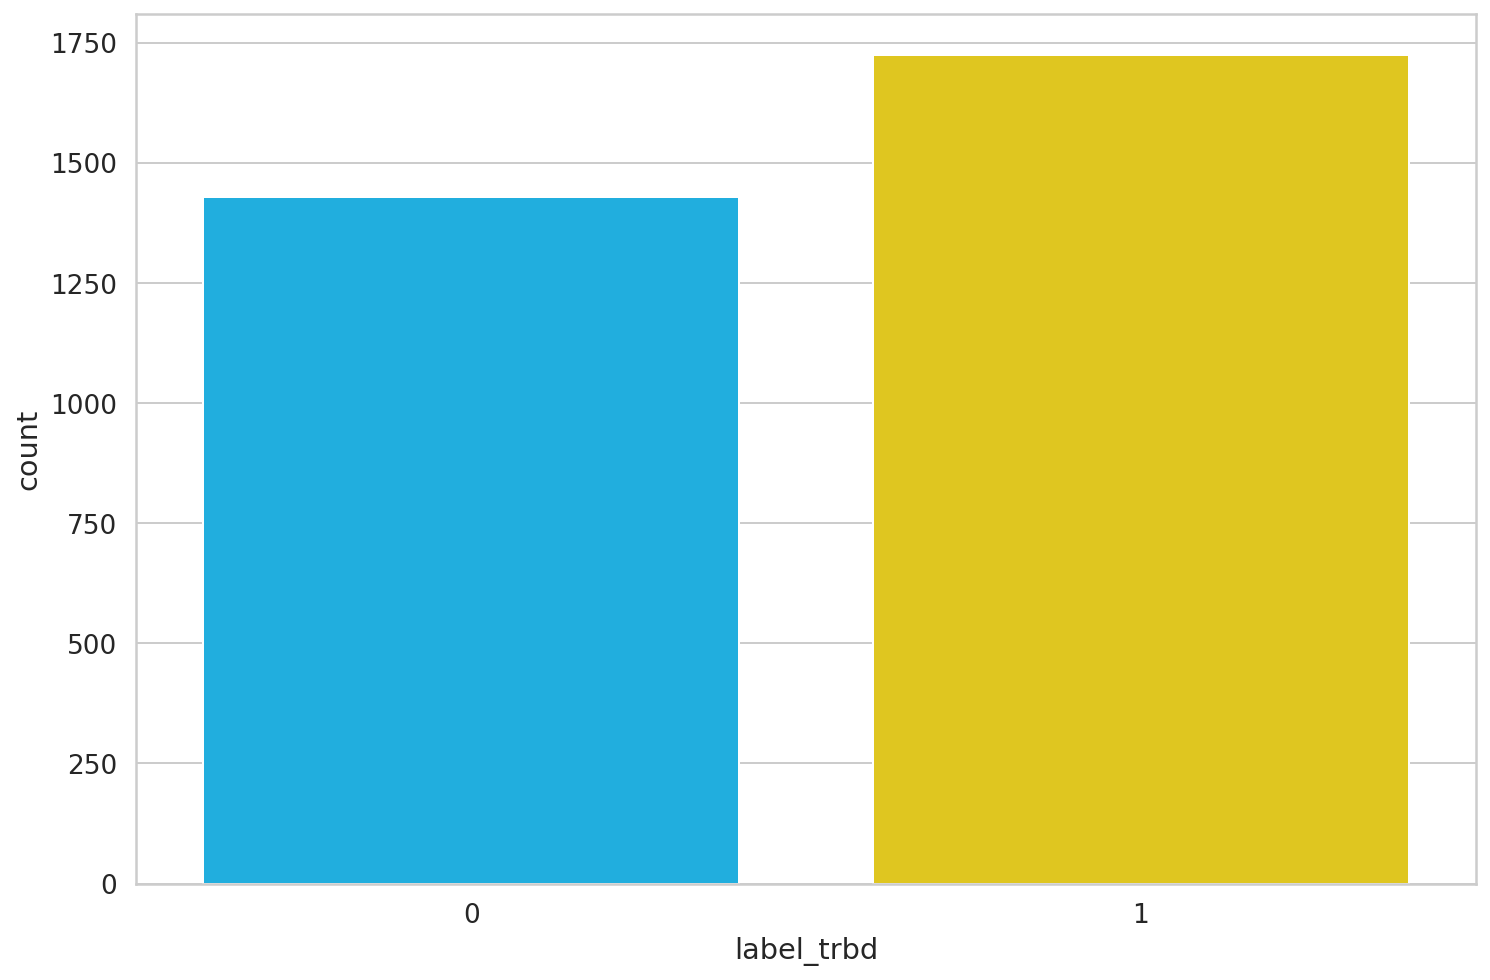

In [ ]:
sns.countplot(dftrbd['label_trbd'])

In [ ]:
df = dftrbd.copy()

## Data Preprocessing

In [ ]:
# We used bert-base-cased model from transformer's library
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
# Download tokenizer from pretrained model
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Arranged the max length of a text to 160
# we found this as somehow a good practice
MAX_LEN = 160

In [ ]:
# We defined a class YoutubeCommentsDataset
# class has the member variables comments,targets,
# tokenizer and max_len

# We encode the comments with pre-trained BERT's
# tokenizer 

class YoutubeCommentsDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    # comments and targets should be numpy arrays
    # tokenizer should be BERT's tokenizer
    # max_len is an integer variable

    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comments)
  
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    # We return a dictionary with comment text
    # input ids, attention mask and targets
    # each designed to be used in torch DataLoader class
    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  # function gets a pandas dataframe with additional parameters
  # and it returns a torch DataLoad class with the dataset given as
  # an input

  ds = YoutubeCommentsDataset(
    comments=df.comments.to_numpy(),
    targets=df.label_trbd.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# Define the train, test and validation splits

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((2523, 7), (315, 7), (316, 7))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


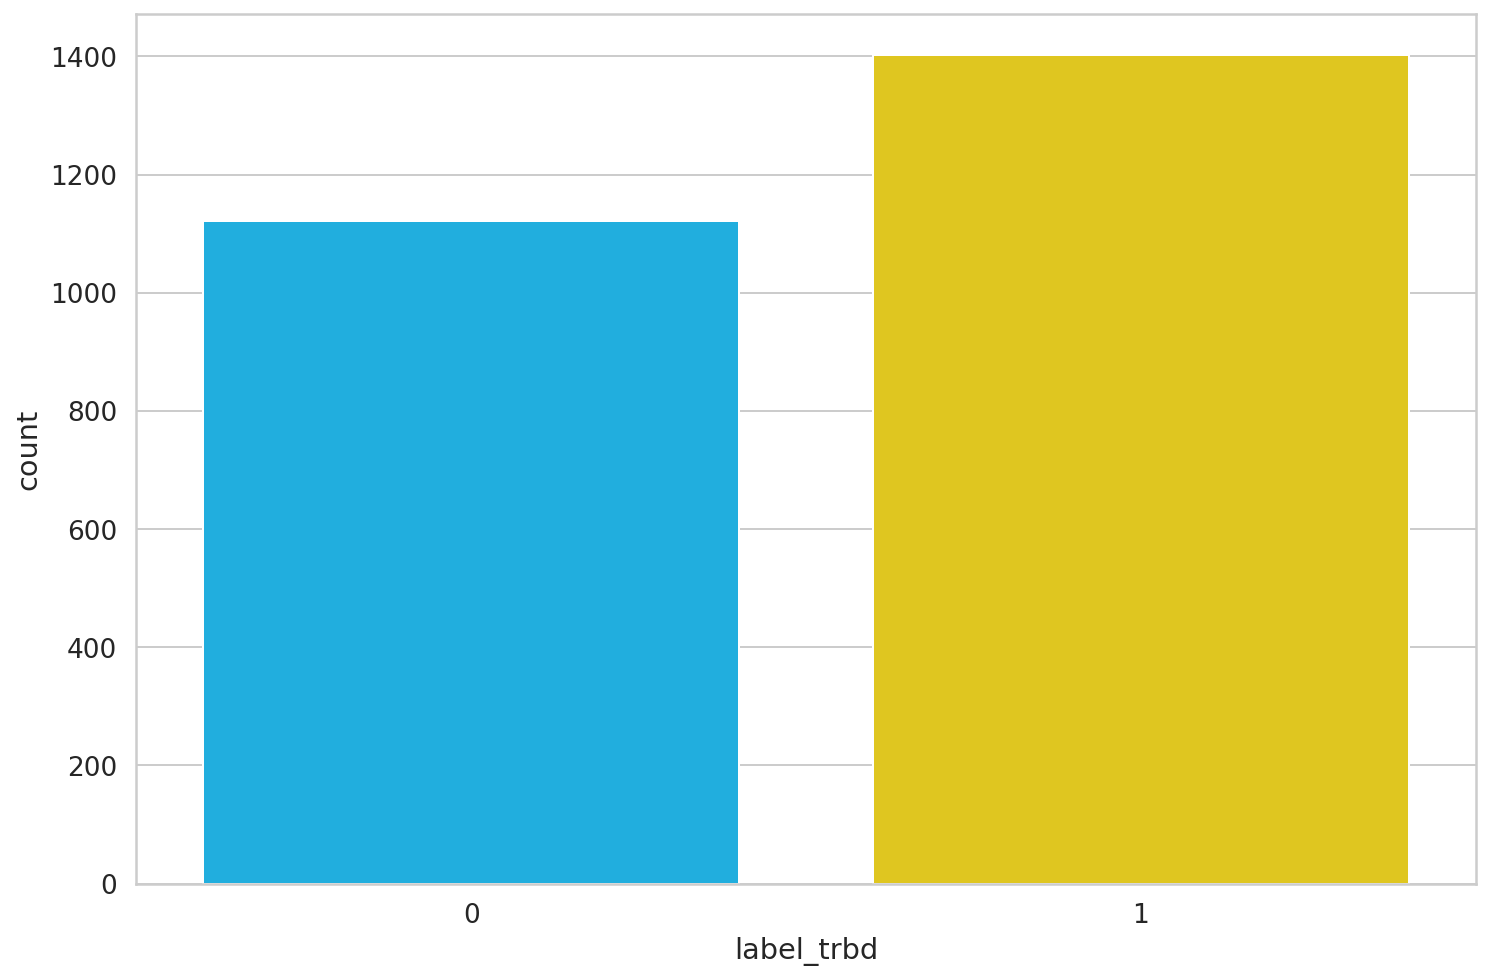

In [ ]:
sns.countplot(df_train['label_trbd'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


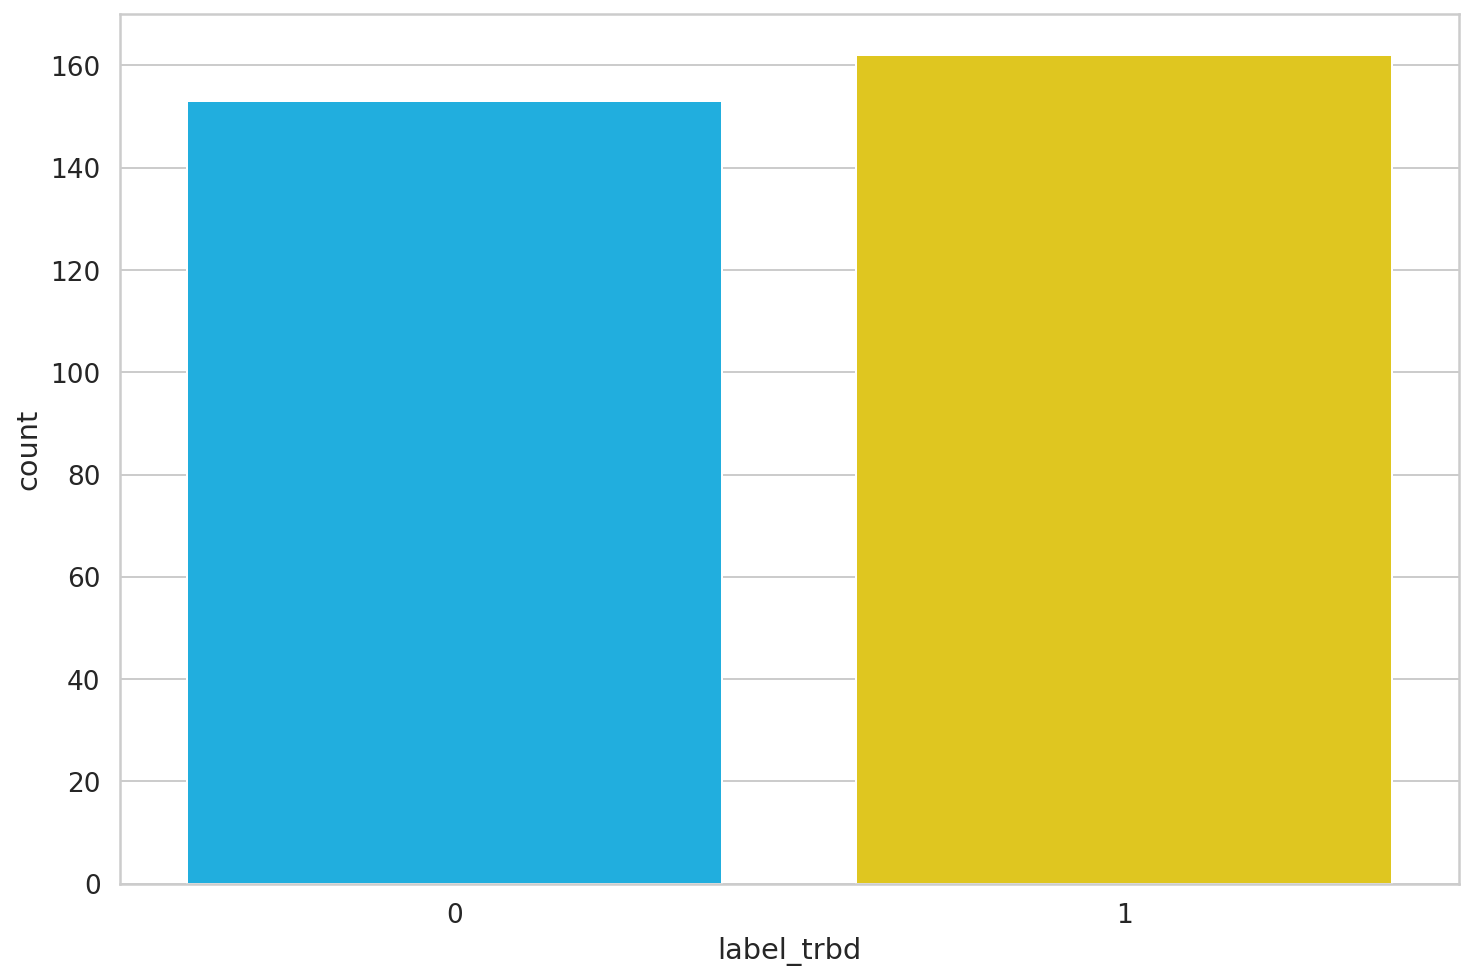

In [ ]:
sns.countplot(df_val['label_trbd'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


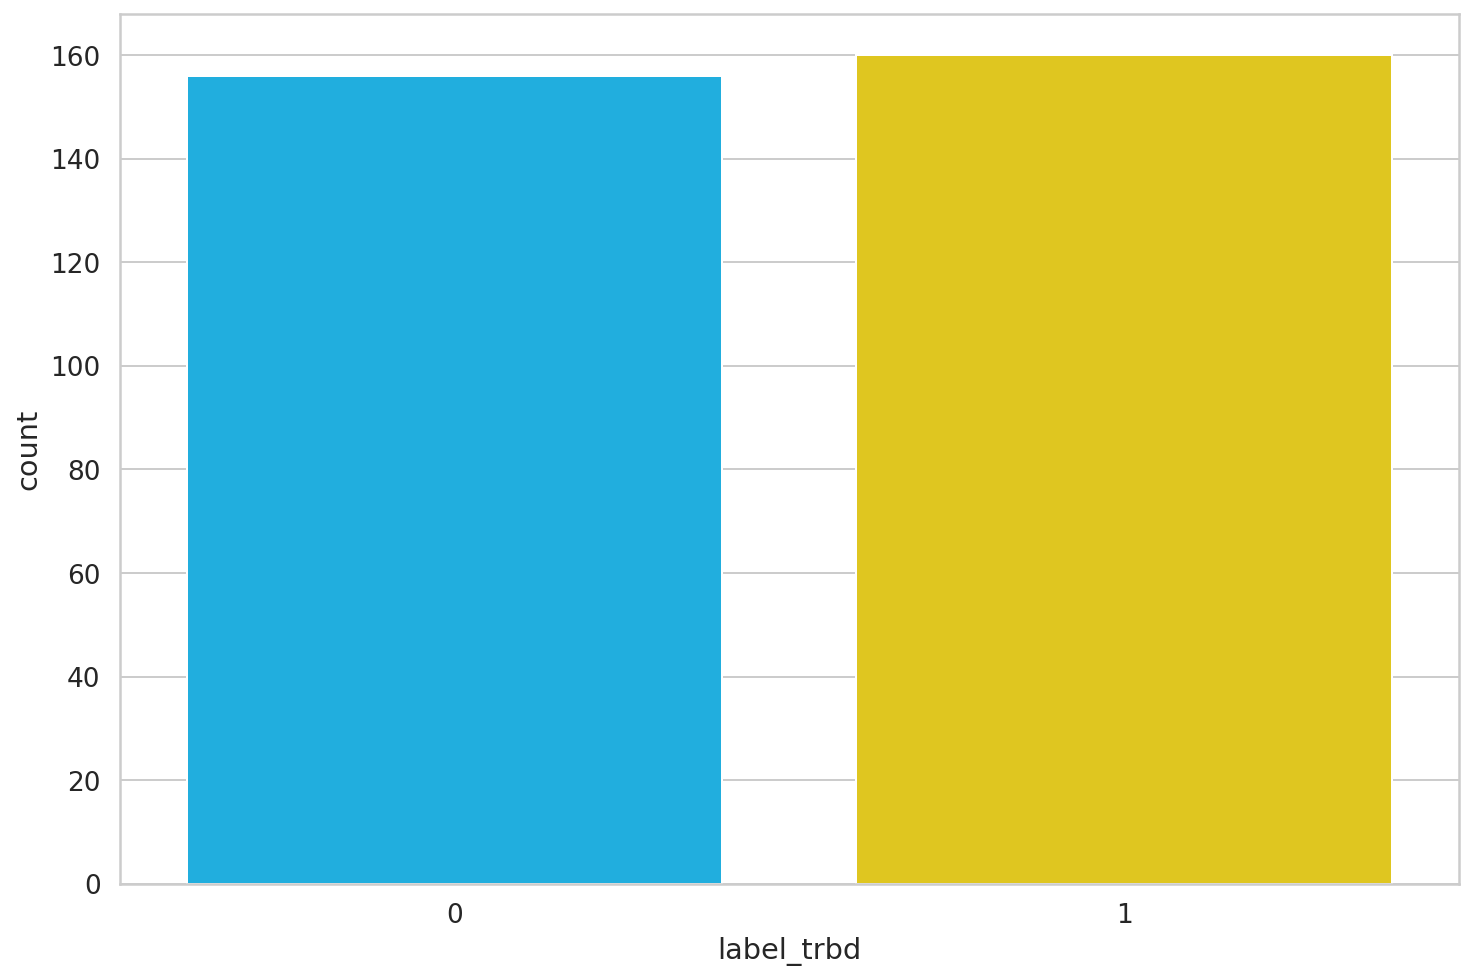

In [ ]:
sns.countplot(df_test['label_trbd'])

In [ ]:
# Define BATCH_SIZE as 16 
BATCH_SIZE = 16

# Create torch data loaders for train, test and validation datasets

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Download BERT Model



In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# SentimentClassifier Model class definition
class SentimentClassifier(nn.Module):

  # We give most of the heavy work to the BertModel. 
  # We used a dropout layer for a regularization 
  # and a fully connected layer for the output. 
  # We  return the raw output of the last layer 
  # because it is required for the cross-entropy 
  # loss function in PyTorch to work.

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# Create an instance of the model
# and move it to the GPU

model = SentimentClassifier(2)
model = model.to(device)

## Training

In [ ]:
# define the EPOCHS
EPOCHS = 7

# We used AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

# We used alinear scheduler
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# defined the loss function as CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# definiton of helper function train_epoch
# takes the inputs model, data_loader, loss function
# optimizer, device, scheduler and number of examples
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  # run the model.train() function
  model = model.train()

  losses = []
  correct_predictions = 0
  
  # for each comment in the data loader run the loop
  for d in data_loader:
    # move the input ids, attention mask and targets to the device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    # take the output of the model when given input ids and 
    # attention mask as input
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # take predictions and loss
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    # calculate correct predictions
    # append loss to the losses
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # run backward function of loss 
    # make the updates
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip grad norm we clip the gradients on every batch
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# model evaluation helper function
# with the input parameters model, data_loader
# loss_fn, device, number of examples
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    # similar steps that we followed on the training but
    # no backward and update part
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

# run the epochs and print the train and validation
# sets' accuracy and loss
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


Epoch 1/7
----------
Train loss 0.5205749520395375 accuracy 0.743559254855331
Val   loss 0.3353253245353699 accuracy 0.8571428571428571

Epoch 2/7
----------
Train loss 0.29929407431355004 accuracy 0.8870392390011891
Val   loss 0.3915131241083145 accuracy 0.873015873015873

Epoch 3/7
----------
Train loss 0.1436235342776002 accuracy 0.9548156956004756
Val   loss 0.502526358794421 accuracy 0.8761904761904762

Epoch 4/7
----------
Train loss 0.0765787799112481 accuracy 0.9778042013476022
Val   loss 0.5207283223513514 accuracy 0.8984126984126984

Epoch 5/7
----------
Train loss 0.025443193916809048 accuracy 0.9936583432421721
Val   loss 0.6014696498401463 accuracy 0.8888888888888888

Epoch 6/7
----------
Train loss 0.006743701605426142 accuracy 0.9980182322631788
Val   loss 0.702407456561923 accuracy 0.8825396825396825

Epoch 7/7
----------
Train loss 0.005814884745448097 accuracy 0.9984145858105431
Val   loss 0.7338030755519866 accuracy 0.8825396825396825

CPU times: user 5min 27s, sys: 

In [ ]:
# We save the model to the drive if needed

torch.save(model.state_dict(), '/content/drive/MyDrive/Applied NLP with Deep Learning/trump_biden_model_new.bin')

In [ ]:
#PATH = "/content/drive/MyDrive/Applied NLP with Deep Learning/trump_biden_model.pt"

# Save
#torch.save(model, PATH)

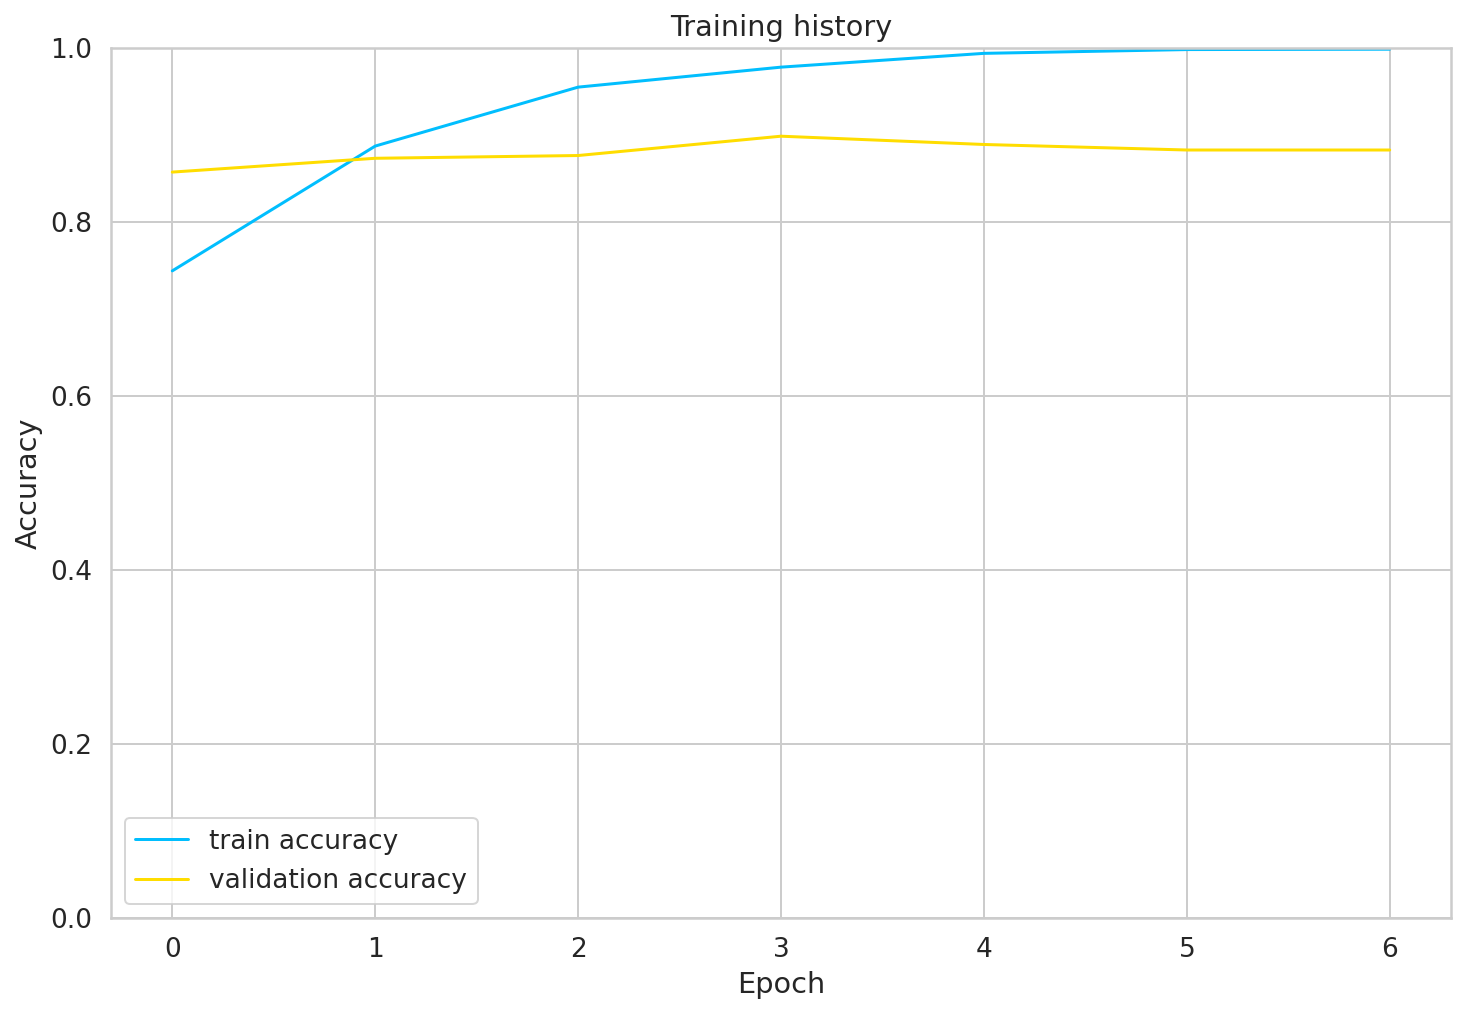

In [ ]:
# Plotting the training and validation accuracies during training
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation


In [ ]:
# Evaluate the model on test set

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8417721518987341

In [ ]:
# function definiton to get predictions from model
# takes model and data_loader as input

# returns comments, predictions
# prediction probabilites and real values
def get_predictions(model, data_loader):
  
  model = model.eval()
  
  comments_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      comments_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return comments_text, predictions, prediction_probs, real_values

In [ ]:
# get predictions
y_comments_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

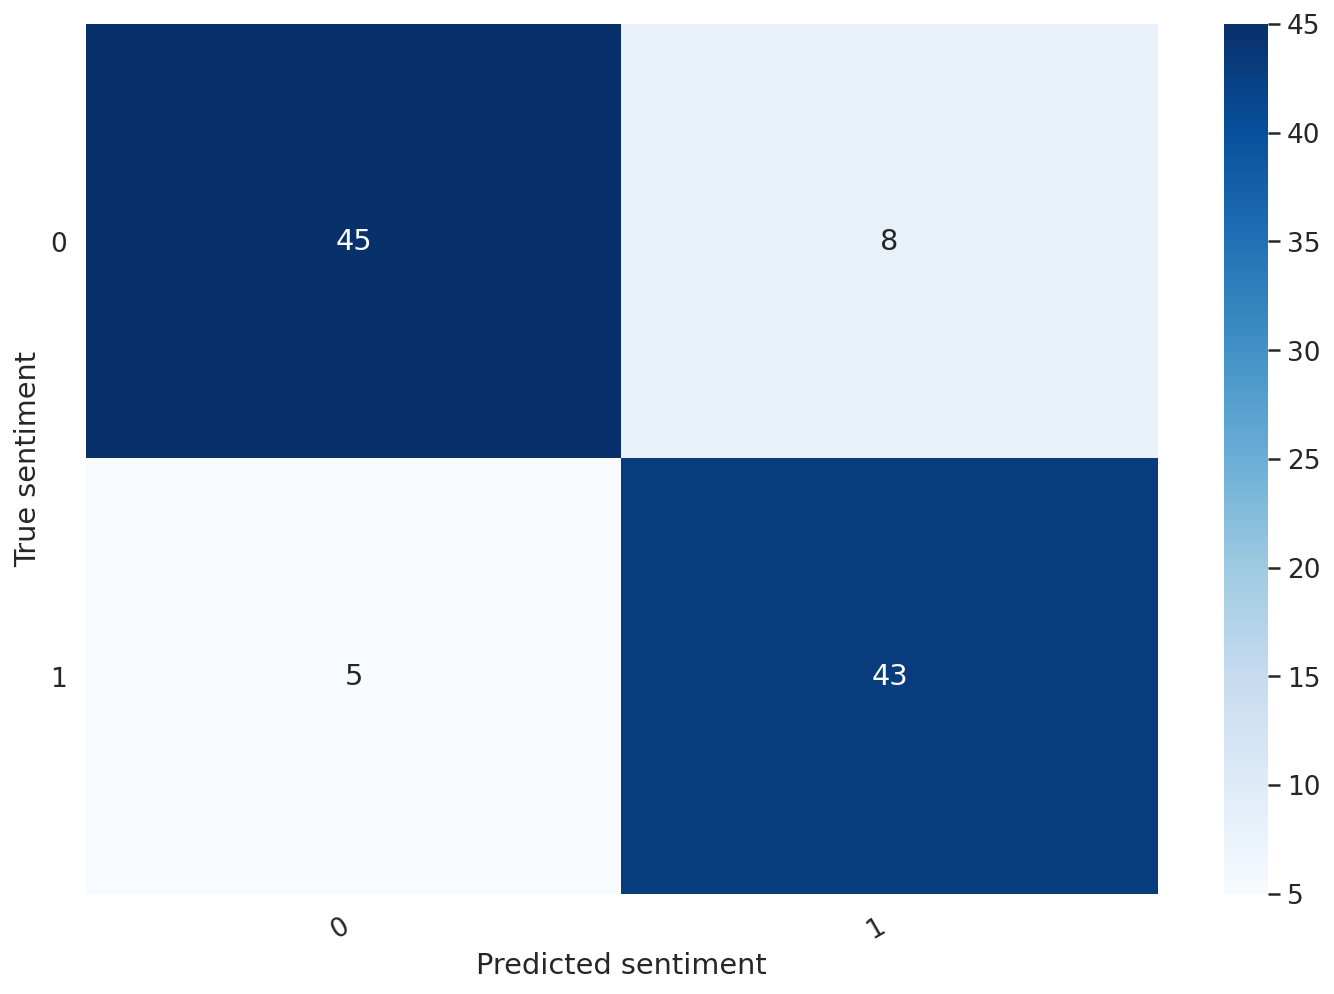

In [ ]:
# create a confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])
show_confusion_matrix(df_cm)

## Predicting on Raw Text



In [ ]:
comment_text = "Finally  someone  with  class      Glad  I  voted  for  you  joe"

In [ ]:
encoded_comment = tokenizer.encode_plus(
  comment_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_comment['input_ids'].to(device)
attention_mask = encoded_comment['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Comment text: {comment_text}')
print(f'Sentiment  : {prediction}')

Comment text: Finally  someone  with  class      Glad  I  voted  for  you  joe
Sentiment  : tensor([1], device='cuda:0')


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)